# Importing modules and initial steps

First we import the utility modules.

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

Now we import the modules needed for the neural net portion of this project.

In [51]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

## Importing the data

Now we decide what stocks we want to predict and load the data using the pandas web datareader and the yahoo finance api.

In [52]:
company = 'GOOGL'

start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)

data = web.DataReader(company, 'yahoo', start, end)

# Preparing data

Now we prepare the data by normalising it between 0 and 1 to make it easier for the NN to work with. We then split the data into it's training dataset and reshape it.

In [53]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x,0])
    y_train.append(scaled_data[x,0])

x_train,y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1))

# Building the Model

Now we can start constructing the model.

In [54]:
model = Sequential()

model.add(LSTM(units = 60, return_sequences = True, input_shape = (x_train.shape[1],1)))

model.add(Dropout(0.2))

model.add(LSTM(units = 60, return_sequences = True))

model.add(Dropout(0.2))

model.add(LSTM(units = 60))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train,y_train, epochs = 25, batch_size = 32)



Epoch 1/25
61/61 [==============================] - 6s 41ms/step - loss: 0.0213
Epoch 2/25
61/61 [==============================] - 2s 41ms/step - loss: 0.0028
Epoch 3/25
61/61 [==============================] - 2s 38ms/step - loss: 0.0026
Epoch 4/25
61/61 [==============================] - 2s 41ms/step - loss: 0.0028
Epoch 5/25
61/61 [==============================] - 2s 39ms/step - loss: 0.0032
Epoch 6/25
61/61 [==============================] - 2s 40ms/step - loss: 0.0024
Epoch 7/25
61/61 [==============================] - 2s 40ms/step - loss: 0.0028
Epoch 8/25
61/61 [==============================] - 3s 43ms/step - loss: 0.0025
Epoch 9/25
61/61 [==============================] - 3s 47ms/step - loss: 0.0023
Epoch 10/25
61/61 [==============================] - 3s 46ms/step - loss: 0.0025
Epoch 11/25
61/61 [==============================] - 3s 46ms/step - loss: 0.0020
Epoch 12/25
61/61 [==============================] - 3s 44ms/step - loss: 0.0020
Epoch 13/25
61/61 [==================

We first test the model by collecting some test data

In [55]:
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis = 0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)



Now we can make predictions on the test data

In [56]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, [x_test.shape[0],x_test.shape[1],1])

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


# Plotting the Predictions

Now we can plot the predicted prices

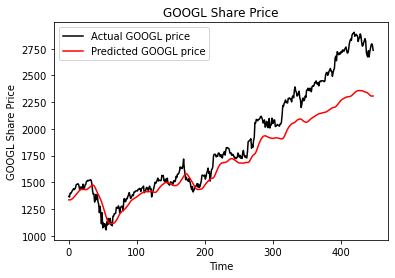

In [57]:
plt.plot(actual_prices, color = "black", label = f"Actual {company} price")
plt.plot(predicted_prices, color = "red", label = f"Predicted {company} price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.show()

We can also find the mean percentage error of the predictions.

In [58]:
abs_sum = 0
for x in range(0,len(actual_prices)):
    abs_sum += abs((actual_prices[x] - predicted_prices[x,0])/actual_prices[x])
mean_error = (abs_sum/len(actual_prices))*100
print(f"The mean percentage error on the measurement was: {round(mean_error,3)}%")

The mean percentage error on the measurement was: 7.679%


# Predicting the stock price tomorrow

Now we can attempt to predict the stock price tomorrow using the NN.

In [60]:
real_data = [model_inputs[len(model_inputs)+1 - prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0],real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction : {prediction[0,0]}")


Prediction : 2308.841064453125
